In [1]:
import numpy as np
import pandas as pd
import math
import time
import matplotlib.pyplot as plt
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from model.LongShortTermMemory import LongShortTermMemory as LSTM
import pickle
from utils import *
%matplotlib inline
torch.set_printoptions(precision=8)

In [2]:
# init paramters
seed = 100
time_step = 100
batch_size = 32
learning_rate = 1e-5
hidden_size = 500
n_layers = 3
n_child_features = 5

# steup using GPU or CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
set_rand_seed(seed)


Random Seed:  100


In [3]:
# load FinTech data
df = pd.read_csv('./data/FinTech.csv', encoding='utf-8')
df.describe()

,DXYUSD_Open,DXYUSD_High,DXYUSD_Low,DXYUSD_Close,DXYUSD_AdjClose,World_Index_Open,World_Index_High,World_Index_Low,World_Index_Close,World_Index_AdjClose,...,VIX_Low,VIX_Close,VIX_AdjClose,TNXTbill_Open,TNXTbill_High,TNXTbill_Low,TNXTbill_Close,TNXTbill_AdjClose,sentiment,Return
count,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,...,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000,1910.000000
mean,93.037063,93.341670,92.764299,93.058869,93.058869,79.970728,80.308838,79.539733,79.929832,74.090235,...,15.988079,16.802382,16.802382,2.146808,2.170868,2.122675,2.146971,2.146971,0.133745,0.004072
std,6.428785,6.444130,6.371380,6.411762,6.411762,11.206009,11.210723,11.210554,11.216312,13.695053,...,6.757086,7.519748,7.519748,0.639077,0.637051,0.639492,0.637137,0.637137,0.048497,0.048865
min,79.139999,79.239998,78.910004,79.139999,79.139999,59.000000,59.000000,58.980000,59.000000,50.273331,...,8.840000,9.140000,9.140000,0.484000,0.538000,0.398000,0.499000,0.499000,-0.238979,-0.351903
25%,90.322500,90.617498,90.070000,90.362501,90.362501,71.122501,71.379997,70.702497,71.045000,62.914810,...,12.252500,12.642500,12.642500,1.817250,1.845000,1.790750,1.815500,1.815500,0.102053,-0.015518
50%,95.180000,95.524998,94.924999,95.169998,95.169998,76.445003,76.895001,75.950000,76.559998,70.956318,...,13.865000,14.460000,14.460000,2.271500,2.295000,2.245500,2.268000,2.268000,0.125821,0.002161
75%,97.427500,97.687502,97.160004,97.419998,97.419998,89.180000,89.477502,88.697498,89.145001,84.892201,...,17.237500,18.407500,18.407500,2.610750,2.633250,2.585750,2.605750,2.605750,0.160976,0.022501
max,103.260002,103.820000,103.029999,103.290001,103.290001,112.940002,112.940002,112.050003,112.139999,112.139999,...,70.370003,82.690002,82.690002,3.239000,3.248000,3.233000,3.234000,3.234000,0.646698,0.369460


In [4]:
# Divide the data set into inputs and outputs
df_input = df.drop(['Return'], axis=1).values[:, :]
df_ouput = df[['Return']].values

# df_input = df.drop(['BTC_Price'], axis=1).values
# df_ouput = df[['BTC_Price']].values

n_samples, n_features = df_input.shape[0], df_input.shape[-1]
print(df_input.shape, df_ouput.shape)


# split data to train and test set
# X_train, X_test, Y_train, Y_test = train_test_split(df_input, df_ouput, test_size=0.2, random_state=1, shuffle=True)
n_train = int(n_samples * 0.8)
X_train, X_test = df_input[:n_train], df_input[n_train:]
Y_train, Y_test = df_ouput[:n_train], df_ouput[n_train:]


# # Normalized data (mean:0, std:1)
X_train_scaler = StandardScaler()
Y_train_scaler = StandardScaler()
X_test_scaler = StandardScaler()
Y_test_scaler = StandardScaler()

X_train = X_train_scaler.fit_transform(X_train)
X_test = X_test_scaler.fit_transform(X_test)
Y_train = Y_train_scaler.fit_transform(Y_train)
Y_test = Y_test_scaler.fit_transform(Y_test)

print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

# built timeseries data for LSTM
X_train, Y_train = time_sequence(X_train, Y_train, time_step=time_step)
X_test, Y_test = time_sequence(X_test, Y_test, time_step=time_step)

# make DataLoader for train and evaluation
train_loader = DataLoader(TensorDataset(X_train, Y_train), batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, Y_test), batch_size, shuffle=False)
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(1910, 51) (1910, 1)
(1528, 51) (1528, 1) (382, 51) (382, 1)
torch.Size([1429, 100, 51]) torch.Size([1429, 1]) torch.Size([283, 100, 51]) torch.Size([283, 1])


In [5]:
# X_train.mean(axis=0), X_train.std(axis=0), X_test.mean(axis=0), X_test.std(axis=0)

In [5]:
Y_train.mean(axis=0), Y_train.std(axis=0), Y_test.mean(axis=0), Y_test.std(axis=0)

(tensor([0.00267206]),
 tensor([0.99424863]),
 tensor([0.02317841]),
 tensor([0.94218147]))

In [6]:
# 'R2 score'
def accuracy1(preds, y):
    SSE = torch.sum(torch.square(y - preds))
    SST = torch.sum(torch.square(y - torch.mean(y)))
    return 1 - (SSE/SST)

def accuracy2(preds, y):
    SSR = torch.sum(torch.square(preds - torch.mean(y)))
    SST = torch.sum(torch.square(y - torch.mean(y)))
    return (SSR/SST)
# adjust R2 score
# def accuracy(preds, y):
#     n = preds.size(0)
#     SSE = torch.sum(torch.square(y - preds))
#     SST = torch.sum(torch.square(y - torch.mean(y)))
#     return 1-((n-1)/(n-n_features))*(SSE/SST)

# def accuracy(preds, y):
#     n = preds.size(0)
#     SSR = torch.sum(torch.square(preds - torch.mean(y)))
#     SST = torch.sum(torch.square(y - torch.mean(y)))
#     return 1-(1-SSR/SST)*(n-1)/(n-n_features-1)


def train(model, iterator, optimizer, criteon):
    
    avg_loss = []
    avg_acc = []
    model.train() 
    
    for batch_id, batch_data in enumerate(iterator):
        inputs, labels = batch_data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        model.hidden = model.init_hidden(inputs.shape[0])
        pred, _ = model(inputs)
        
#         print(pred.shape, labels.shape)
        loss = criteon(pred.squeeze(), labels.squeeze())
        acc = accuracy2(pred.squeeze(), labels.squeeze()).item()

        avg_loss.append(loss.item())
        avg_acc.append(acc)

        model.zero_grad()
        loss.backward()
        optimizer.step()
        
    avg_acc = np.array(avg_acc).mean()
    avg_loss = np.array(avg_loss).mean()
    return avg_loss, avg_acc

def predict(model, inputs):
    model.eval()
#     dec_inputs = torch.zeros(labels.size(0), labels.size(-1), 1).long().to(device)
    
    model.hidden = model.init_hidden(inputs.shape[0])
    
    inputs = inputs.to(device)
    pred, _ = model(inputs)
    return pred

def evaluate(model, iterator, criteon):

    avg_loss = []
    avg_acc = []
    model.eval()
    att_weights = []
    
    with torch.no_grad():
        for batch_data in iterator:
            
            inputs, labels = batch_data
            inputs = inputs.to(device)
            labels = labels.to(device)
            model.hidden = model.init_hidden(inputs.shape[0])
            pred, attention_weight = model(inputs)
#             att_weights.append(attention_weight.squeeze())
            loss = criteon(pred.squeeze(), labels.squeeze())
            acc = accuracy2(pred.squeeze(), labels.squeeze()).item()

            avg_loss.append(loss.item())
            avg_acc.append(acc)

    avg_loss = np.array(avg_loss).mean()
    avg_acc = np.array(avg_acc).mean()
    return avg_loss, avg_acc, att_weights

In [7]:
# built LSTM model
model = LSTM(time_step, n_features, hidden_size=hidden_size, n_layers=n_layers, n_child_features=n_child_features).to(device)

optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
# optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.95)
criteon = nn.MSELoss()
warmup_epochs = 10
warmup_scheduler = WarmUpLR(optimizer, warmup_epochs)
optimizer_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=500,eta_min=0, last_epoch=-1)

In [10]:
# from torchinfo import summary
# x = torch.randn(batch_size, time_step, n_features).to(device)
# print(summary(model, input_data=x, device="cuda", verbose=1, col_names=["input_size", "kernel_size", "output_size", "num_params"]))

Epoch:  1 | Epoch Time: 0.0m 0.52s
	Train Loss: 0.969113 | Train Acc: 0.65142%
	 Val. Loss: 0.974392 |  Val. Acc: 2.29177%


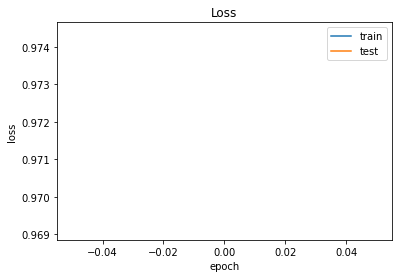

Epoch: 51 | Epoch Time: 0.0m 0.45s
	Train Loss: 0.972855 | Train Acc: 0.52969%
	 Val. Loss: 0.973076 |  Val. Acc: 1.78824%
Epoch: 101 | Epoch Time: 0.0m 0.40s
	Train Loss: 0.963905 | Train Acc: 2.38732%
	 Val. Loss: 0.968600 |  Val. Acc: 1.30918%
Epoch: 151 | Epoch Time: 0.0m 0.41s
	Train Loss: 0.955489 | Train Acc: 1.59257%
	 Val. Loss: 0.968742 |  Val. Acc: 1.14643%
Early Stoping!!
Epoch: 167 | Epoch Time: 0.0m 0.44s
	Train Loss: 0.954313 | Train Acc: 2.43233%
	 Val. Loss: 0.969378 |  Val. Acc: 1.20528%


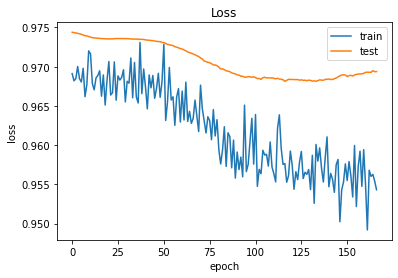

In [9]:
#train and print model
best_valid_acc = float('-inf')

early_stoping_iters = 50
count = 0
epochs = 1000
loss_train = []
loss_test = []
eastop = False
min_loss = 1e8
early_stoping_start = 100

for epoch in range(epochs):

    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criteon)
    dev_loss, dev_acc, att_weights = evaluate(model, test_loader, criteon)
    
    end_time = time.time()
    
    if epoch < warmup_epochs:
        warmup_scheduler.step()
    else:
        optimizer_scheduler.step()
    loss_train.append(train_loss)
    loss_test.append(dev_loss)
#     optimizer_scheduler.step()
    epoch_mins, epoch_secs = divmod(end_time - start_time, 60)

    if dev_loss <= min(loss_test): 
        torch.save(model.state_dict(), './model/lstm-model.pt')
    if epoch > early_stoping_start and dev_loss < min_loss:
        min_loss = dev_loss
    if dev_loss > min_loss and epoch > early_stoping_start:
        count+=1
    else:
        count=0
    if count == early_stoping_iters:
        print("Early Stoping!!")
        eastop = True
    if epoch % 50 == 0 or epoch == epochs-1 or eastop:
        print(f'Epoch: {epoch+1:2} | Epoch Time: {epoch_mins}m {epoch_secs:.2f}s')
        print(f'\tTrain Loss: {train_loss:.6f} | Train Acc: {train_acc*100:.5f}%')
        print(f'\t Val. Loss: {dev_loss:.6f} |  Val. Acc: {dev_acc*100:.5f}%')
    if count == early_stoping_iters:
        break
    if epoch % 200 == 0:
        plot_loss(loss_train, loss_test)
plot_loss(loss_train, loss_test)

In [9]:
# # #use srored model to predice 
# model.load_state_dict(torch.load("./model/lstm-model.pt"))
# model.eval()
# test_loss, test_acc, att_weights = evaluate(model, test_iterator, criteon)
# print(f'Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc*100:.2f}%')
# # model.eval()

RuntimeError: Error(s) in loading state_dict for LongShortTermMemory:
	size mismatch for aggregate.0.1.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.0.1.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.0.1.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.0.1.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.0.5.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.0.5.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.0.5.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.0.5.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.1.1.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.1.1.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.1.1.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.1.1.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.1.5.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.1.5.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.1.5.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.1.5.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.2.1.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.2.1.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.2.1.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.2.1.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.2.5.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.2.5.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.2.5.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.2.5.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.3.1.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.3.1.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.3.1.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.3.1.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.3.5.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.3.5.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.3.5.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.3.5.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.4.1.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.4.1.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.4.1.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.4.1.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.4.5.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.4.5.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.4.5.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.4.5.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.5.1.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.5.1.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.5.1.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.5.1.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.5.5.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.5.5.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.5.5.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.5.5.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.6.1.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.6.1.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.6.1.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.6.1.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.6.5.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.6.5.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.6.5.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.6.5.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.7.1.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.7.1.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.7.1.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.7.1.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.7.5.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.7.5.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.7.5.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.7.5.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.8.1.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.8.1.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.8.1.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.8.1.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.8.5.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.8.5.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.8.5.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.8.5.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.9.1.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.9.1.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.9.1.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.9.1.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.9.5.weight: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.9.5.bias: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.9.5.running_mean: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for aggregate.9.5.running_var: copying a param with shape torch.Size([5]) from checkpoint, the shape in current model is torch.Size([100]).

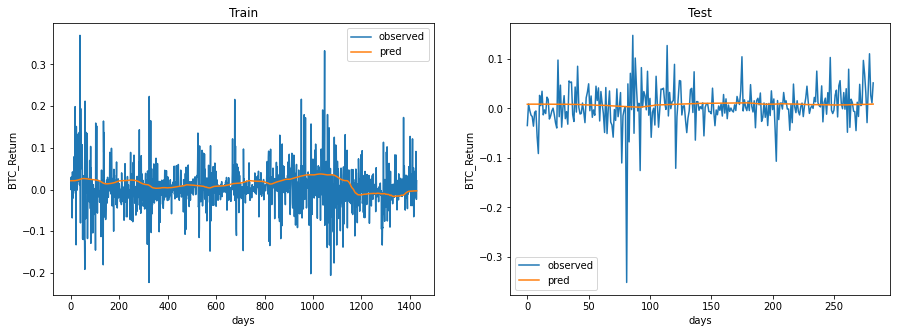

tensor(-0.07891953) tensor(0.11234877) 0.0026354045 0.002460405667619882
tensor(-0.00421286) tensor(0.00676118) 0.0018137277 0.0018318679460365952


In [11]:
train_pre_list = []
test_pre_list = []
for i in range(X_train.shape[0]):
    train_pre = predict(model, X_train[i].reshape(1,time_step,-1))
    train_pre_list.append(train_pre.cpu().detach().numpy())
for i in range(X_test.shape[0]):
    test_pre = predict(model, X_test[i].reshape(1,time_step,-1))
    test_pre_list.append(test_pre.cpu().detach().numpy())
train_pre = np.vstack(train_pre_list)
test_pre = np.vstack(test_pre_list)

# print(criteon(train_pre, Y_train), criteon(test_pre, Y_test))
train_pre = Y_train_scaler.inverse_transform(train_pre)
yytrain = Y_train_scaler.inverse_transform(Y_train)
test_pre = Y_test_scaler.inverse_transform(test_pre)
yytest = Y_test_scaler.inverse_transform(Y_test)

# plot prediction and true values
#进行绘图
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(yytrain)
plt.plot(train_pre)
plt.xlabel('days')
plt.ylabel('BTC_Return')
plt.legend(['observed', 'pred'])
plt.title('Train')
plt.subplot(122)
plt.plot(yytest)
plt.plot(test_pre)
plt.xlabel('days')
plt.ylabel('BTC_Return')
plt.legend(['observed', 'pred'])
plt.title('Test')
plt.show() 


from sklearn.metrics import mean_squared_error
print(accuracy1(torch.Tensor(train_pre), torch.Tensor(yytrain)), accuracy2(torch.Tensor(train_pre), torch.Tensor(yytrain)), 
      mean_squared_error(train_pre, yytrain), mean_squared_error(np.zeros([yytrain.shape[0], 1]), yytrain))
print(accuracy1(torch.Tensor(test_pre), torch.Tensor(yytest)), accuracy2(torch.Tensor(test_pre), torch.Tensor(yytest)),
      mean_squared_error(test_pre, yytest),  mean_squared_error(np.zeros([yytest.shape[0], 1]), yytest))

In [12]:
# dy / dx
import copy
delta_x = 1e-5
print(X_test.shape)
cols = df.columns[:-1]
newcols = []
dy = []
i = 0
while i < X_test.shape[-1]:
    new_X_test = copy.deepcopy(X_test)
    if i < 50:
        new_X_test[:, :, i:i+5] += delta_x
        newcols.append(''.join(cols[i].split('_')[0])+ '_aggregation')
        i += 5
    else:
        new_X_test[:, :, i] += delta_x
        newcols.append(cols[i])
        i += 1
#     new
    train_pre_list = []
    test_pre_list = []
    for j in range(X_train.shape[0]):
        train_pre = predict(model, X_train[j].reshape(1,time_step,-1))
        train_pre_list.append(train_pre.cpu().detach().numpy())
    for i in range(X_test.shape[0]):
        test_pre = predict(model, X_test[j].reshape(1,time_step,-1))
        test_pre_list.append(test_pre.cpu().detach().numpy())
    train_pre = np.vstack(train_pre_list)
    test_pre = np.vstack(test_pre_list)
#     print((y1 - y0).cpu().detach().numpy())
    dy.append(((y1 - y0).cpu().detach().numpy() / delta_x).reshape(-1))
dy = np.array(dy).T
dy.mean(axis=0)

# dev_loss, dev_acc, att_weights = evaluate(model, test_loader, criteon)
# att = torch.cat(att_weights, dim=0).cpu()
# pd.DataFrame(att.numpy().sum(axis=0).reshape(-1, 1))
df_coef = pd.DataFrame(columns=['variable', 'coefficient'])
df_coef['variable'] = newcols
df_coef['coefficient'] = dy.mean(axis=0)
df_coef['class'] = df_coef['variable'].apply(lambda x:x.split('_')[0])
df_coef['abs_coefficient'] = df_coef['coefficient'].abs()
# sort by absolute value of coefficient
df_agg_coef = df_coef.groupby(by='class').mean()
df_agg_coef = df_agg_coef.reset_index()
df_agg_coef.sort_values(by='abs_coefficient', ascending=False)[:15].reset_index(drop=True)
df_coef.sort_values(by='abs_coefficient', ascending=False)[:30].reset_index(drop=True)[['variable', 'coefficient', 'abs_coefficient']]

torch.Size([283, 100, 51])


,variable,coefficient,abs_coefficient
0,VIX_aggregation,-0.395376,0.395376
1,sentiment,-0.294067,0.294067
2,TNXTbill_aggregation,-0.234114,0.234114
3,SPY_aggregation,-0.072792,0.072792
4,DXYUSD_aggregation,0.011707,0.011707
5,World_aggregation,-0.007171,0.007171
6,Silver_aggregation,-0.005599,0.005599
7,GoldUSD_aggregation,0.004459,0.004459
8,DBCCommodity_aggregation,-0.003118,0.003118
9,DJCI_aggregation,-0.001462,0.001462


In [ ]:
# # # save to res
# # # load result
# if os.path.exists('./result/LSTM_result.pkl'):
#     res = pickle.load(open('./result/LSTM_result.pkl', 'rb'))
# else:
#     res = {}
# info = {}
# info['Describe'] = 'Only price inforamtion was used to predict Return'
# info['Variables'] = newcols
# info['Model_Parameters'] = {'lr':learning_rate, 'L2':1e-5, 'epochs':epochs, 'batch_size':batch_size, 'hidden_size':hidden_size, 'LSTM_layers':n_layers}
# info['R2score'] = {'accuracy1':[accuracy1(torch.Tensor(train_pre), torch.Tensor(yytrain)), accuracy1(torch.Tensor(test_pre), torch.Tensor(yytest))], 
#                    'accuracy2':[accuracy2(torch.Tensor(train_pre), torch.Tensor(yytrain)), accuracy2(torch.Tensor(test_pre), torch.Tensor(yytest))]}
# info['Timestep'] = time_step
# info['MeanSquaredError'] = [mean_squared_error(train_pre, yytrain), mean_squared_error(test_pre, yytest)]
# info['Coefficient'] = dy.mean(axis=0)
# res['LSTM_'+str(len(res))] = info
# # save result
# with open('./result/LSTM_result.pkl', 'wb') as f:
#     pickle.dump(res, f)
# res

In [ ]:
# # 数据分布检查
# # load FinTech data
# new_df = pd.read_csv('./data/FinTech.csv', encoding='utf-8')
# new_df = new_df.drop(['DJCI__volatility', 'sentiment', 'World_Index__volatility', 'DXYUSD__volatility'], axis=1)
# # df = df.loc[500:]
# # df
# # df_ouput = df_ouput.reset_index(drop=True)
# train_rate = 0.8
# n_train = int(train_rate * new_df.shape[0])
# df_train = new_df[:n_train]
# test = new_df[n_train:]

# # cols = ['SPY__volatility', 'CrudeOil__Return', 'VIX__volatility', 'CrudeOil__volatility']
# # train = train.drop(cols, axis=1)
# # test = test.drop(cols, axis=1)

# X_train = df_train.drop(['Return'], axis=1).values
# Y_train = np.ones([X_train.shape[0],1])
# X_test = test.drop(['Return'], axis=1).values
# Y_test = np.zeros([X_test.shape[0],1])
# inp = np.vstack([X_train, X_test])
# label = np.vstack([Y_train, Y_test])
# inp = StandardScaler().fit_transform(inp)

# n_samples, n_features = inp.shape